In [1]:
## Files required for this example at /uscms/home/fnavarro/nobackup/nano_darkhiggs_files/ 
import uproot, uproot_methods
import numpy as np
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import fnal_column_analysis_tools
from histbook import *
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from awkward import JaggedArray, Table
from vega import VegaLite as canvas                
import vega

# Fnal_column_analysis_tools

Provides tools to make traditionally looped process in a vectorical way. It also loads scalefactor histograms from root, json and csv files and allows vectorial evaluation.

In [2]:

extractor = fnal_column_analysis_tools.lookup_tools.extractor()
extractor.add_weight_sets(['* * lookup_tables/eleTrig.root','* * lookup_tables/muon_trig_Run2016BtoF.root',
                           '* * lookup_tables/ScaleFactor_etracker_80x.json', 
                            '* * lookup_tables/EIDISO_WH_out.json','* * lookup_tables/Tight27AfterIDISO_out.json', '* * lookup_tables/failingVeto_out.json', 
                            '* * lookup_tables/ElectronID_SFs_WP90.root', '* * lookup_tables/kfactor_24bins.root'])
extractor.finalize()

evaluator = extractor.make_evaluator()


/home/felipe/.local/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:614: RuntimeWarning: overflow encountered in sinh
  z = pt * awkward.util.numpy.sinh(eta)
/home/felipe/.local/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:614: RuntimeWarning: invalid value encountered in multiply
  z = pt * awkward.util.numpy.sinh(eta)
/home/felipe/.local/lib/python2.7/site-packages/fnal_column_analysis_tools/analysis_objects/JaggedCandidateArray.py:16: RuntimeWarning: divide by zero encountered in arctanh
  return np.arctanh(pz/p3mag)


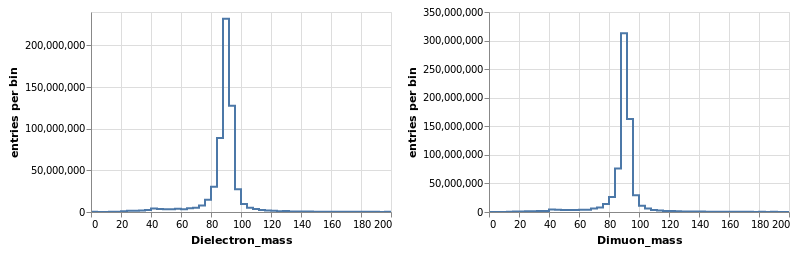

In [3]:

hist1 = Hist(bin("Dielectron_mass",50,0,200),weight='e_weight')
hist11 = Hist(bin("Dielectron_mass_down",50,0,200),weight='e_weight')
hist2 = Hist(bin("Dimuon_mass",50,0,200),weight='m_weight')



met_trigger_paths = ["HLT_PFMET170_NoiseCleaned",
            "HLT_PFMET170_HBHECleaned",
            "HLT_PFMET170_JetIdCleaned",
            "HLT_PFMET170_NotCleaned",
            #"HLT_PFMET170_HBHE_BeamHaloCleaned",
            #"HLT_PFMETNoMu120_NoiseCleaned_PFMHTNoMu120_IDTight",
            #"HLT_PFMETNoMu110_NoiseCleaned_PFMHTNoMu110_IDTight",
            #"HLT_PFMETNoMu90_NoiseCleaned_PFMHTNoMu90_IDTight",
            "HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "HLT_PFMETNoMu120_PFMHTNoMu120_IDTight"]
met_trigger_columns = {path:path for path in met_trigger_paths}

singleele_trigger_paths = [#"HLT_Ele27_WP85_Gsf",
          "HLT_Ele27_WPLoose_Gsf",
          "HLT_Ele105_CaloIdVT_GsfTrkIdT",
          "HLT_Ele27_WPTight_Gsf",
          #"HLT_Ele30_WPTight_Gsf",
          "HLT_Ele27_eta2p1_WPTight_Gsf",
          "HLT_Ele32_eta2p1_WPTight_Gsf",
          "HLT_Ele35_WPLoose_Gsf",
          "HLT_ECALHT800"]
singleele_trigger_columns = {path:path for path in singleele_trigger_paths}

singlephoton_trigger_paths = ["HLT_Photon175",
          #"HLT_Photon200",
          "HLT_Photon165_HE10",
          "HLT_Photon36_R9Id90_HE10_IsoM",
          "HLT_Photon50_R9Id90_HE10_IsoM",
          "HLT_Photon75_R9Id90_HE10_IsoM",
          "HLT_Photon90_R9Id90_HE10_IsoM",
          "HLT_Photon120_R9Id90_HE10_IsoM",
          "HLT_Photon165_R9Id90_HE10_IsoM",
          "HLT_Photon300_NoHE",
          "HLT_ECALHT800",
          "HLT_CaloJet500_NoJetID"]
singlephoton_trigger_columns = {path:path for path in singlephoton_trigger_paths}


electron_columns = {'pt':'Electron_pt','eta':'Electron_eta','phi':'Electron_phi','mass':'Electron_mass','iso':'Electron_pfRelIso03_all','dxy':'Electron_dxy','dz':'Electron_dz',
                    'cutBased_HLTPreSel':'Electron_cutBased_HLTPreSel','mvaSpring16GP_WP80':'Electron_mvaSpring16GP_WP80','id':'Electron_mvaSpring16GP_WP90','charge':'Electron_charge',
                    'pdgId':'Electron_pdgId','deltaEtaSC':'Electron_deltaEtaSC'}

muon_columns = {'pt':'Muon_pt','eta':'Muon_eta','phi':'Muon_phi','mass':'Muon_mass','iso':'Muon_pfRelIso04_all','dxy':'Muon_dxy','dz':'Muon_dz','charge':'Muon_charge','tightId':'Muon_tightId',
                 'pdgId':'Muon_pdgId'}

jet_columns = {'pt':'Jet_pt','eta':'Jet_eta','phi':'Jet_phi','mass':'Jet_mass','id':'Jet_jetId'}

tau_columns = {'pt':'Tau_pt','eta':'Tau_eta','phi':'Tau_phi','mass':'Tau_mass','decayMode':'Tau_idDecayMode','decayModeNew':'Tau_idDecayModeNewDMs','id':'Tau_idMVAnew'} # (idmVAnewDM does not exist in my file) idMVAnew

photon_columns = {'pt':'Photon_pt','eta':'Photon_eta','phi':'Photon_phi','mass':'Photon_mass',}

gen_columns = {'pt':'GenPart_pt','eta':'GenPart_eta','phi':'GenPart_phi','mass':'GenPart_mass','id':'GenPart_pdgId','status':'GenPart_status', 'statusFlags':'GenPart_statusFlags','mIdx':'GenPart_genPartIdxMother'}

all_columns = [electron_columns,muon_columns,jet_columns,photon_columns,met_trigger_columns,singleele_trigger_columns,singlephoton_trigger_columns,tau_columns,gen_columns]

columns = []
for cols in all_columns: columns.extend(list(cols.values()))





# In[2]:


# Functions

def wgt(pt): # For TT pt sf
    return np.exp(0.0615 - 0.0005 * np.clip(pt, 0, 800))


# In[3]:



for arrays in uproot.iterate('test_coffeabeans/ZZ*.root','Events',columns,entrysteps=5000):
     
        # initialize phyisics objects
	triggers =  {'MET':np.prod([arrays[val] for val in met_trigger_columns], axis=0),
						'SingleEle':np.prod([arrays[val] for val in singleele_trigger_columns],axis=0),
						'SinglePhoton':np.prod([arrays[val] for val in singlephoton_trigger_columns],axis=0)
                }
      
	electrons = JaggedCandidateArray.candidatesfromcounts(arrays[electron_columns['pt']].counts, **{key:arrays[val].content for key,val in electron_columns.items()})                                                             
	muons = JaggedCandidateArray.candidatesfromcounts(arrays[muon_columns['pt']].counts, **{key:arrays[val].content for key,val in muon_columns.items()})
	taus = JaggedCandidateArray.candidatesfromcounts(arrays[tau_columns['pt']].counts, **{key:arrays[val].content for key,val in tau_columns.items()})                     
	photons = JaggedCandidateArray.candidatesfromcounts(arrays[photon_columns['pt']].counts, **{key:arrays[val].content for key,val in photon_columns.items()})                                                   
	jets = JaggedCandidateArray.candidatesfromcounts(arrays[jet_columns['pt']].counts, **{key:arrays[val].content for key,val in jet_columns.items()})
	genPart = JaggedCandidateArray.candidatesfromcounts(arrays[gen_columns['pt']].counts, **{key:arrays[val].content for key,val in gen_columns.items()})
	
	# Scale Farctors to be used
	sf_qcdV = np.ones(genPart.size)
	topptWeight = np.ones(genPart.size)
	vptWeightEWK = np.ones(genPart.size)
	sfReco = np.ones(electrons.size)
	sfReco_up = np.ones(electrons.size)
	sfReco_down = np.ones(electrons.size)
	sfTrig = np.ones(electrons.size)
	sfTrig_up = np.ones(electrons.size)
	sfTrig_down = np.ones(electrons.size)
	sfFailVeto = np.ones(electrons.size)
	sfFailVeto_up = np.ones(electrons.size)
	sfFailVeto_down = np.ones(electrons.size)
	sfIdIso = np.ones(electrons.size)
	sfIdIso_up = np.ones(electrons.size)
	sfIdIso_down = np.ones(electrons.size)
	sfId = np.ones(electrons.size)
	sfId_up = np.ones(electrons.size)
	sfId_down = np.ones(electrons.size)
	
	weights = np.ones(genPart.size)
	weights_up = np.ones(genPart.size)
	weights_down = np.ones(genPart.size)
	# end initialize
		# physical objects selection
	loose_electron_selection = (electrons.pt>7)&(abs(electrons.eta)<2.4)&(abs(electrons.dxy)<0.05)&(abs(electrons.dz)<0.2)&(electrons.iso<0.4)#&(electrons.id)
	loose_muon_selection =  (muons.pt>5)&(abs(muons.eta)<2.4)&(abs(muons.dxy)<0.5)&(abs(muons.dz)<1.0)&(muons.iso<0.4)
	loose_photon_selection = (photons.pt>15)*(abs(photons.eta)<2.5)
	tau_selection = (taus.pt>18)&(abs(taus.eta)<2.3)&(taus.decayMode)&((taus.id&2)!=0)
	jet_selection = (jets.pt>25)&(abs(jets.eta)<4.5)&((jets.id&2)!=0)
    
	loose_electrons = electrons[loose_electron_selection]
	loose_muons = muons[loose_muon_selection]
	loose_photons = photons[loose_photon_selection]
	selected_taus = taus[tau_selection]
	selected_jets = jets[jet_selection]
		# end seletion
    
        # lepton cleaned jets
	jet_combinations = selected_jets.p4.cross(loose_electrons.p4, nested=True)
	mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3 ).any()
	e_clean_jets = selected_jets[~mask]
    
	jet_combinations = e_clean_jets.p4.cross(loose_muons.p4, nested=True)
	mask = (jet_combinations.i0.delta_r(jet_combinations.i1) < 0.3).any()
	clean_jets = e_clean_jets[~mask]
    
    # once merge is done
    # mask = selected_jets.p4.match(clean_electrons.p4, 0.3)
    # clean_jets = selected_jets[~mask]
        # end cleaning
    
    #V boson matching
	VBosons_mass = np.zeros(clean_jets.size)
	VBosons_mass[clean_jets.counts >1] = (clean_jets.p4[clean_jets.counts > 1][:,0] + clean_jets.p4[clean_jets.counts >1][:,1]).mass
	VBosons_mass[clean_jets.counts ==1] = (clean_jets.p4[clean_jets.counts == 1][:,0]).mass

	target = 23
	genVBosons = genPart[(genPart.id==target)&(genPart[genPart.mIdx].id != target)]
	sf_qcdV[genVBosons.counts>0] = evaluator['ZJets_012j_NLO/nominal'](genVBosons.pt)[:,0]
        # weights evaluation
	
	genTops = genPart[abs(genPart.id)==6]
	genWs = genPart[abs(genPart.id)==24]
	genZs = genPart[abs(genPart.id)==23]
	genHs = genPart[abs(genPart.id)==25]
    
	topptWeight[genTops.counts > 1] = np.sqrt(wgt(genTops[genTops.counts >1].pt[:,0]) * wgt(genTops[genTops.counts > 1].pt[:,1]))
   
	vptWeightEWK_first_selection = (genWs.counts==1)&(genZs.counts==0)&(genHs.counts==0)&(genTops.counts==0)
	vptWeightEWK[vptWeightEWK_first_selection] = (-0.830041 + 7.93714 * (np.power(genWs[vptWeightEWK_first_selection].pt[:,0] + 877.978, -0.213831))) 
	vptWeightEWK[vptWeightEWK_first_selection][(genWs[vptWeightEWK_first_selection].pt[:,0]<100)&(genWs[vptWeightEWK_first_selection].pt[:,0]>=3000)]=1.
    
	vptWeightEWK_second_selection = (genWs.counts==0)&(genZs.counts==1)&(genHs.counts==0)&(genTops.counts==0)
	vptWeightEWK[vptWeightEWK_second_selection] = (-0.1808051 + 6.04146 * (np.power(genZs[vptWeightEWK_second_selection].pt[:,0] + 759.098, -0.242556))) 
	vptWeightEWK[vptWeightEWK_second_selection][(genZs[vptWeightEWK_second_selection].pt[:,0]<100)&(genZs[vptWeightEWK_second_selection].pt[:,0]>=3000)]=1.
    
	_1L_electron_selection = (loose_electrons.counts == 1)&(loose_electrons.pt > 30)&(loose_electrons.id)&(loose_electrons.mvaSpring16GP_WP80)&(loose_electrons.iso < 0.06)#&(loose_electrons.cutBased_HLTPreSel)
	_1L_muon_selection = (loose_muons.pt > 25)&(loose_muons.tightId)&(loose_muons.iso < 0.06)
	_2L_electron_selection = ((loose_electrons.counts + loose_muons.counts) >= 2)&(loose_electrons.pt > 20)&(loose_electrons.iso < 0.15)
	_2L_muon_selection = ((loose_electrons.counts + loose_muons.counts) >= 2)&(loose_muons.pt > 20)&(loose_muons.iso < 0.25)
	
	_1L_electrons = loose_electrons[_1L_electron_selection]
	_1L_muons = loose_muons[_1L_muon_selection]
	_2L_electrons = loose_electrons[_2L_electron_selection]
	_2L_muons = loose_muons[_2L_muon_selection]
			
	
	genPart_1LSfe_selection = (abs(genPart.id==11))&(genPart.statusFlags&1 !=0)&(genPart.statusFlags&8192 != 0)
	genPart_1LSfm_selection = (abs(genPart.id==13))&(genPart.statusFlags&1 !=0)&(genPart.statusFlags&8192 != 0)
	gen_prompt_electrons = genPart[genPart_1LSfe_selection]
	gen_prompt_muons = genPart[genPart_1LSfm_selection]
	gen_electrons_combinations = _1L_electrons.p4.cross(gen_prompt_electrons.p4,nested=True)
	gen_electrons_combinations = _1L_electrons.p4.cross(gen_prompt_electrons.p4,nested=True)
	gen_electrons_mask = (gen_electrons_combinations.i0.delta_r(gen_electrons_combinations.i1)<0.4).any()
	
	_1L_electrons = _1L_electrons[gen_electrons_mask]
	
	# 1L channel weights
	
	sfReco[_1L_electrons.counts >0] = evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts > 0]
	sfReco_up[_1L_electrons.counts >0] = sfReco[_1L_electrons.counts > 0] + evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts > 0]
	sfReco_down[_1L_electrons.counts >0] = sfReco[_1L_electrons.counts > 0] - evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts > 0]
	sfReco_up[ _1L_electrons.counts > 0][_1L_electrons[_1L_electrons.counts >0].pt[:,0] >80] = sfReco_up[ _1L_electrons.counts > 0][_1L_electrons[_1L_electrons.counts >0].pt[:,0] >80] + 0.01
	sfReco_down[ _1L_electrons.counts > 0][_1L_electrons[_1L_electrons.counts >0].pt[:,0] >80] = sfReco_down[ _1L_electrons.counts > 0][_1L_electrons[_1L_electrons.counts >0].pt[:,0] >80] - 0.01
	
	sfIdIso[_1L_electrons.counts >0] = evaluator['EIDISO_WH/eta_pt_ratio_value'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts >0]
	sfIdIso_up[_1L_electrons.counts >0] = sfIdIso[_1L_electrons.counts > 0] + evaluator['EIDISO_WH/eta_pt_ratio_error'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts >0]
	sfIdIso_down[_1L_electrons.counts >0] =sfIdIso[_1L_electrons.counts > 0] - evaluator['EIDISO_WH/eta_pt_ratio_error'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts >0]
	
	sfTrig[_1L_electrons.counts >0] = evaluator['Tight27AfterIDISO/eta_pt_ratio_value'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts >0]
	sfTrig_up[_1L_electrons.counts >0] = sfTrig[_1L_electrons.counts > 0] + evaluator['Tight27AfterIDISO/eta_pt_ratio_error'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts >0]
	sfTrig_down[_1L_electrons.counts >0] =sfTrig[_1L_electrons.counts > 0] - evaluator['Tight27AfterIDISO/eta_pt_ratio_error'](_1L_electrons.eta+_1L_electrons.deltaEtaSC,_1L_electrons.pt)[_1L_electrons.counts >0]
	
	# 2L channle weights
		#ee case selection
	_2L_ee_selection = (_2L_electrons.counts > 1)&(_2L_muons.counts == 0)
	_2L_ee_electrons = _2L_electrons[_2L_ee_selection]
		#em case selection
	
	_2L_em_selection = (_2L_electrons.counts == 1)&(_2L_muons.counts == 1)
	_2L_em_electrons = _2L_electrons[_2L_em_selection]
	_2L_em_muons = _2L_muons[_2L_em_selection]
	_2L_em_selection2 = (_2L_em_electrons.pt[:,0]>_2L_em_muons.pt[:,0])
	_2L_em_electrons = _2L_em_electrons[_2L_em_selection2]
	_2L_em_muons = _2L_em_muons[_2L_em_selection2]
	
	
		#ee+ m+ case selection
	_2L_eem_selection = (_2L_electrons.counts > 1)&(_2L_muons.counts >= 1)
	_2L_eem_electrons = _2L_electrons[_2L_eem_selection]
	_2L_eem_muons = _2L_muons[_2L_eem_selection]
	_2L_eem_selection2 = (_2L_eem_electrons.pt[:,0]>_2L_eem_muons[:,0])
	_2L_eem_electrons = _2L_eem_electrons[_2L_eem_selection2]
	_2L_eem_muons = _2L_eem_muons[_2L_eem_selection2]
	_2L_eem_selection3 = (_2L_eem_electrons.pt[:,1]>_2L_eem_muons[:,0])
	_2L_eem_selection4 = (_2L_eem_muons.pt[:,0]>_2L_eem_electrons[:,1])
	
	#ee case evaluation
	if _2L_ee_electrons.size !=0:
		gen_ee_combinations = _2L_ee_electrons.p4[:,:2].cross(gen_prompt_electrons[_2L_ee_selection].p4,nested=True)
		gen_ee_mask = (gen_ee_combinations.i0.delta_r(gen_ee_combinations.i1)<0.4).any()
		_2L_ee_electrons = _2L_ee_electrons[:,:2][gen_ee_mask]
		
		sfReco[_2L_ee_selection][_2L_ee_electrons.counts <0] = evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts <0][:,0]
		sfReco[_2L_ee_selection][_2L_ee_electrons.counts ==2] = sfReco[_2L_ee_selection][_2L_ee_electrons.counts ==2]*evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts ==2][:,1]
		sfReco_up[_2L_ee_selection][_2L_ee_electrons.counts <0] = sfReco[_2L_ee_selection][_2L_ee_electrons.counts <0]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts <0][:,0]
		sfReco_up[_2L_ee_selection][_2L_ee_electrons.counts ==2] = sfReco_up[_2L_ee_selection][_2L_ee_electrons.counts ==2]*(sfReco[_2L_ee_selection][_2L_ee_electrons.counts ==2]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts ==2][:,1])
		sfReco_down[_2L_ee_selection][_2L_ee_electrons.counts <0] = sfReco[_2L_ee_selection][_2L_ee_electrons.counts <0]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts <0][:,0]
		sfReco_down[_2L_ee_selection][_2L_ee_electrons.counts ==2] = sfReco_down[_2L_ee_selection][_2L_ee_electrons.counts ==2]*(sfReco[_2L_ee_selection][_2L_ee_electrons.counts ==2]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts ==2][:,1])
		
		sfId[_2L_ee_selection][_2L_ee_electrons.counts <0] = evaluator['EGamma_SF2D'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts <0][:,0]
		sfId[_2L_ee_selection][_2L_ee_electrons.counts ==2] = sfId[_2L_ee_selection][_2L_ee_electrons.counts ==2]*evaluator['EGamma_SF2D'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_ee_selection][_2L_ee_electrons.counts ==2][:,1]
		

		
	#em case evaluation
	if _2L_em_electrons.size !=0:
		
		gen_em_e_combinations = _2L_em_electrons.p4[:,:1].cross(gen_prompt_electrons[_2L_em_selection][_2L_em_selection2].p4,nested=True)
		gen_em_e_mask = (gen_em_e_combinations.i0.delta_r(gen_em_e_combinations.i1)<0.4).any()
		_2L_em_electrons = _2L_em_electrons[:,:1][gen_em_e_mask]
		
		gen_em_m_combinations = _2L_em_muons.p4[:,:1].cross(gen_prompt_muons[_2L_em_selection][_2L_em_selection2].p4,nested=True)
		gen_em_m_mask = (gen_em_m_combinations.i0.delta_r(gen_em_m_combinations.i1)<0.4).any()
		_2L_em_muons = _2L_em_muons[:,:1][gen_em_m_mask]
		
		sfReco[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1] = evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1][:,0]
		sfReco[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)] = sfReco[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)]*evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_muons.eta ,_2L_muons.pt)[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)][:,0]
		sfReco_up[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1] = sfReco[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1][:,0]
		sfReco_up[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)] = sfReco_up[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)]*(sfReco[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_muons.eta,_2L_muons.pt)[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)][:,0])
		sfReco_down[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1] = sfReco[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1][:,0]
		sfReco_down[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)] = sfReco_down[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)]*(sfReco[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_muons.eta,_2L_muons.pt)[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)][:,0])
		
		sfId[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1] = evaluator['EGamma_SF2D'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_em_selection][_2L_em_selection2][_2L_em_electrons.counts ==1][:,0]
		sfId[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)] = sfId[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)]*evaluator['EGamma_SF2D'](_2L_muons.eta ,_2L_muons.pt)[_2L_em_selection][_2L_em_selection2][(_2L_em_muons.counts ==1)&(_2L_em_electrons.counts ==1)][:,0]
		

	#eem case evaluation
		# top two highest pt are electrons
	_2L_eem_electrons_ee = _2L_eem_electrons[_2L_eem_selection3]
	if _2L_eem_electrons_ee.size !=0:
		gen_eem_e_combinations = _2L_eem_electrons_ee.p4[:,:1].cross(gen_prompt_electrons[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3].p4,nested=True)
		gen_eem_e_mask = (gen_eem_e_combinations.i0.delta_r(gen_eem_e_combinations.i1)<0.4).any()
		_2L_eem_electrons_ee1 = _2L_eem_electrons_ee[:,:1][gen_eem_e_mask]
		
		gen_eem_e2_combinations = _2L_eem_electrons_ee.p4[:,1:2].cross(gen_prompt_electrons[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3].p4,nested=True)
		gen_eem_e2_mask = (gen_eem_e_combinations.i0.delta_r(gen_eem_e_combinations.i1)<0.4).any()
		_2L_eem_electrons_ee2 = _2L_eem_electrons_ee[:,1:2][gen_eem_e_mask]
		
		e_sel = _2L_eem_electrons_ee1.counts > 0
		e2_sel = _2L_eem_electrons_ee2.counts > 0
		
		sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel] = evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel][:,0]
		sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel] =sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel]*evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel][0,0]
		sfReco_up[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel] = sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel][:,0]
		sfReco_up[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel] = sfReco_up[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel]*(sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel][:,0])
		sfReco_down[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel] = sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel][:,0]
		sfReco_down[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel] = sfReco_down[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel]*(sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel][:,0])
		
		sfId[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel] = evaluator['EGamma_SF2D'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e_sel][:,0]
		sfId[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel] =sfId[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel]*evaluator['EGamma_SF2D'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection3][e2_sel][0,0]
		

	_2L_eem_electrons_em = _2L_eem_electrons[_2L_eem_selection4]
	_2L_eem_muons_em = _2L_eem_muons[_2L_eem_selection4]
	# top two highest pt are electron and muon
	if _2L_eem_electrons_em.size !=0:
		gen_eem_e_combinations = _2L_eem_electrons_em.p4[:,:1].cross(gen_prompt_electrons[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4].p4,nested=True)
		gen_eem_e_mask = (gen_eem_e_combinations.i0.delta_r(gen_eem_e_combinations.i1)<0.4).any()
		_2L_eem_electrons_em = _2L_eem_electrons_em[:,:1][gen_eem_e_mask]
		
		gen_eem_m_combinations = _2L_eem_muons_em.p4[:,:1].cross(gen_prompt_muons[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4].p4,nested=True)
		gen_eem_m_mask = (gen_eem_m_combinations.i0.delta_r(gen_eem_m_combinations.i1)<0.4).any()
		_2L_eem_muons_em = _2L_eem_muons_em[:,:1][gen_eem_m_mask]
		
		e_sel = _2L_eem_electrons_em.counts > 0
		m_sel = _2L_eem_muons_em.counts > 0
		
		sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel] = evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel][:,0]
		sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel] =sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel]*evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_value'](_2L_muons.eta,_2L_muons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel][:,0]
		sfReco_up[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel] = sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel][:,0]
		sfReco_up[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel] = sfReco_up[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel]*(sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel]+evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_muons.eta,_2L_muons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel][:,0])
		sfReco_down[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel] = sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel][:,0]
		sfReco_down[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel] = sfReco_down[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel]*(sfReco[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel]-evaluator['ScaleFactor_tracker_80x/eta_pt_ratio_error'](_2L_muons.eta,_2L_muons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel][:,0])

		sfId[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel] = evaluator['EGamma_SF2D'](_2L_electrons.eta+_2L_electrons.deltaEtaSC,_2L_electrons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][e_sel][:,0]
		sfId[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel] =sfId[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel]*evaluator['EGamma_SF2D'](_2L_muons.eta,_2L_muons.pt)[_2L_eem_selection][_2L_eem_selection2&_2L_eem_selection4][m_sel][:,0]
		
		
        # end weights

        # find dileptons
        
	
	weight = sf_qcdV*topptWeight*vptWeightEWK*sfReco*sfTrig*sfFailVeto*sfIdIso*sfId
	weight_up = sf_qcdV*topptWeight*vptWeightEWK*sfReco_up*sfTrig_up*sfFailVeto*sfIdIso_up*sfId
	weight_down = sf_qcdV*topptWeight*vptWeightEWK*sfReco_down*sfTrig_down*sfFailVeto*sfIdIso_down*sfId
    
	dielectrons = loose_electrons.distincts()
	dielectron_mass = dielectrons.mass
	e_weight = weight[dielectron_mass.counts>0]
	e_weight_down = weight_down[dielectron_mass.counts>0]
	dielectron_mass = dielectron_mass[dielectron_mass.counts>0][:,0]
    
	dimuons = loose_muons.distincts()  # the function distincts returns a jagged array with the sum of the four momentum of all distinct pairs in the original jagged array
	dimuon_mass = dimuons.mass
	m_weight = weight[dimuon_mass.counts>0]
	dimuon_mass = dimuon_mass[dimuon_mass.counts > 0][:,0]
        # end dileptons
    
        # plots

    
    
	hist1.fill(Dielectron_mass=dielectron_mass,e_weight=e_weight)
	hist11.fill(Dielectron_mass_down=dielectron_mass,e_weight=e_weight)
	hist2.fill(Dimuon_mass=dimuon_mass, m_weight=m_weight)
    
        # end plots


# In[4]:




disp = beside(

hist1.step("Dielectron_mass",width=300),
hist2.step("Dimuon_mass",width=300))

display = IPythonDisplay(disp)
display.init()
disp.to(canvas)